# Batch processing our raws

With the latest updates it should now be fairly smooth. 

# Imports and data 

%pip install -U git+https://github.com/fligt/maxrf4u.git

In [1]:
import maxrf4u as mx 
import zarr 
import dask 
import numpy as np
import os 
from glob import glob
import re
import matplotlib.pyplot as plt 
import dask.array as da

from dask_image.ndfilters import gaussian_filter
from zarr.storage import ZipStore
from dask.diagnostics import ProgressBar

In [2]:
os.chdir('..') 
print(f'maxrf4u: {mx.__version__}, zarr: {zarr.__version__}, dask: {dask.__version__}')

maxrf4u: 0.1.37, zarr: 3.0.4, dask: 2024.11.2


In [3]:
!tree --filelimit 10

.
├── data
│   ├── interim
│   │   ├── 02. JPEG Res.zip
│   │   ├── maxrf
│   │   │   ├── datastacks  [16 entries exceeds filelimit, not opening dir]
│   │   │   ├── element-maps
│   │   │   └── previews  [16 entries exceeds filelimit, not opening dir]
│   │   ├── rgb_jpegs-from-tifs  [35 entries exceeds filelimit, not opening dir]
│   │   └── Weimar-PhaseOne-rot270  [72 entries exceeds filelimit, not opening dir]
│   └── raw
│       ├── 03. MSI Phase One.zip
│       ├── filetree.txt
│       └── Weimar-folders
│           ├── Weimar_Keyence
│           │   ├── 18  [86 entries exceeds filelimit, not opening dir]
│           │   ├── 3  [26 entries exceeds filelimit, not opening dir]
│           │   ├── 35  [38 entries exceeds filelimit, not opening dir]
│           │   ├── 8  [25 entries exceeds filelimit, not opening dir]
│           │   ├── christmas  [26 entries exceeds filelimit, not opening dir]
│           │   └── Zofia textiel
│           │       ├── VHX_000252.jpg
│           │  

In [4]:
raw_files = sorted(glob('./data/**/*.raw', recursive=True))
raw_files

['./data/raw/Weimar-folders/Weimar-XRF/71803-01_MA-XRF/WM-71803-01_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-03_MA-XRF/WM-71803-03_250_300_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-08_MA-XRF/WM-71803-08_250_300_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-10_MA-XRF/WM-71803-10_250_300_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-12_MA-XRF/WM-71803-12_250_300_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-13_MA-XRF/WM-71803-13_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-17_MA-XRF/WM-71803-17_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-18_MA-XRF/WM-71803-18_400_500_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-19_MA-XRF/71803-19_MA-XRF_detail-paper-margin/WM-71803-19_400_300_50_det.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-19_MA-XRF/WM-71803-19_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-23_MA-XRF/WM-71803-23_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-X

In [5]:
rpl_files = [re.sub('raw$', 'rpl', f) for f in raw_files]
video_files = sorted(glob('./data/**/*Video*.tif', recursive=True))
object_nums = [re.sub(r'.*(71803-\d\d).*', r'\g<1>', f) for f in raw_files]
raw_sizes = np.array([os.path.getsize(f) for f in raw_files]) // 1e6

video_ims = [plt.imread(f) for f in video_files]

In [6]:
%matplotlib widget

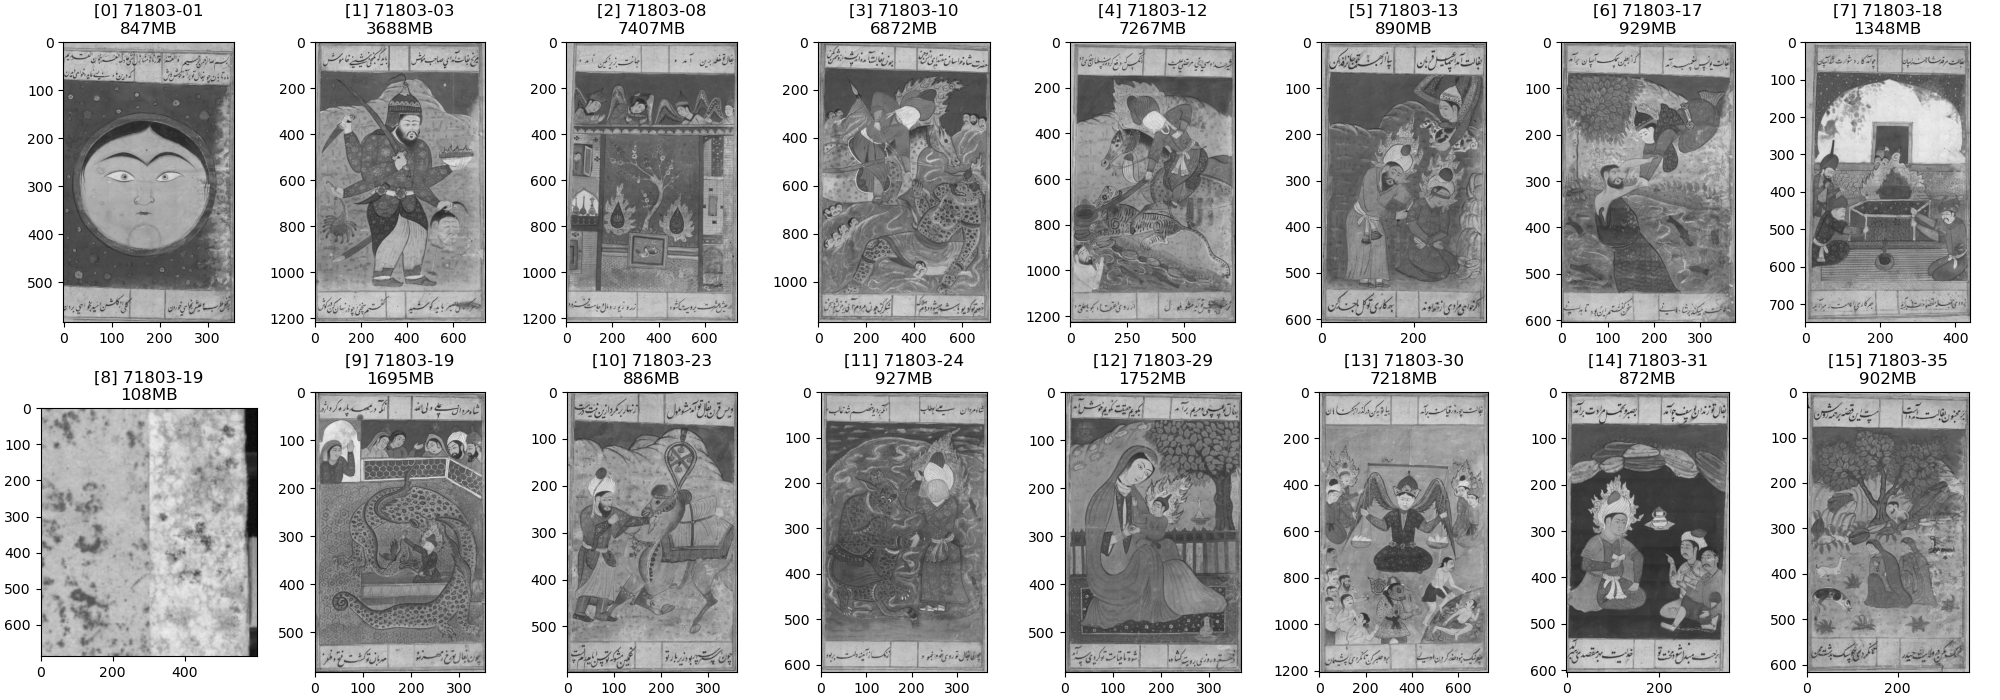

In [7]:
fig, axs = plt.subplots(ncols=8, nrows=2, figsize=[20, 7], layout='constrained')

axs = axs.flatten()

for i, [ax, im, obj_num, size] in enumerate(zip(axs, video_ims, object_nums, raw_sizes)): 
    ax.imshow(im)
    ax.set_title(f'[{i}] {obj_num}\n{int(size)}MB')
    

In [8]:
elements_unsorted = ['S', 'K', 'Ca', 'Ba', 'Ti', 'Cr', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'Au', 'Ag', 'Hg', 'As', 'Pb', 'Sr', 'Zr'] 

for i, [raw_file, rpl_file] in enumerate(zip(raw_files, rpl_files)): 
    n = len(raw_files)
    print(f'\n{i}/{n-1} Creating datastack with element maps from: {raw_file}')
    mx.raw_to_element_maps(elements_unsorted, raw_file, rpl_file) 
    #mx.raw_to_datastack(raw_file, rpl_file, output_dir='./data/interim/maxrf/datastacks/')
    

Datastack finished
Stored at ./data/raw/Weimar-folders/Weimar-XRF/71803-35_MA-XRF/WM-71803-35_400_500_50.datastack


/
├── compton_peak_energy (1,) float64
├── hotmax_baselines (31, 4096) float64
├── hotmax_noiselines (31, 4096) float64
├── hotmax_peak_idxs_flat (34,) int64
├── hotmax_peak_idxs_list (31, 2) int64
├── hotmax_spectra (31, 4096) float32
├── hotmax_spots (31, 2) int64
├── hotmax_subpeak_idxs_list (31, 18) int64
├── maxrf_cube (617, 357, 4096) float32
├── maxrf_energies (4096,) float64
├── maxrf_maxspectrum (4096,) float32
├── maxrf_sumspectrum (4096,) float64
├── nmf_atomnums (18,) int64
├── nmf_elementmaps (18, 617, 357) float32
├── nmf_gausscomponents (35, 4096) float32
├── nmf_peakmaps (35, 617, 357) float32
└── nmf_peaks2elements_matrix (18, 34) float32

./data/raw/Weimar-folders/Weimar-XRF/71803-35_MA-XRF/WM-71803-35_400_500_50.datastack:




Need to check if automatic energy calibration is robust.  

In [5]:
datastack_files = sorted(glob('./data/interim/**/*.datastack', recursive=True)) 
n_files = len(datastack_files)
list(enumerate(datastack_files))

[(0, './data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack'),
 (1, './data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack'),
 (2, './data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack'),
 (3, './data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack'),
 (4, './data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack'),
 (5, './data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack'),
 (6, './data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack'),
 (7, './data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack'),
 (8, './data/interim/maxrf/datastacks/WM-71803-19_400_300_50_det.datastack'),
 (9, './data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack'),
 (10, './data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack'),
 (11, './data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack'),
 (12, './data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack'),
 (13, './data/interim/maxrf/dat

In [6]:
max_spectra = []
for dsf in datastack_files: 
    ds = mx.DataStack(dsf)
    mxs = ds.read('maxrf_maxspectrum')
    max_spectra.append(mxs)

sum_spectra = []
for dsf in datastack_files: 
    ds = mx.DataStack(dsf)
    sms = ds.read('maxrf_sumspectrum')
    sum_spectra.append(sms)

I would like to see a plot... 

In [ ]:
fig, axs = plt.subplots(nrows=n_files, sharex=True, figsize=[15, 15])

axs = axs.flatten()
for i, [ax, mxs, sms] in enumerate(zip(axs, max_spectra, sum_spectra)): 
    ax.plot(mxs, label=f'{i} max')
    ax.plot(sms, label=f'{i} sum')
    ax.legend()

Let's try if calibrate works...

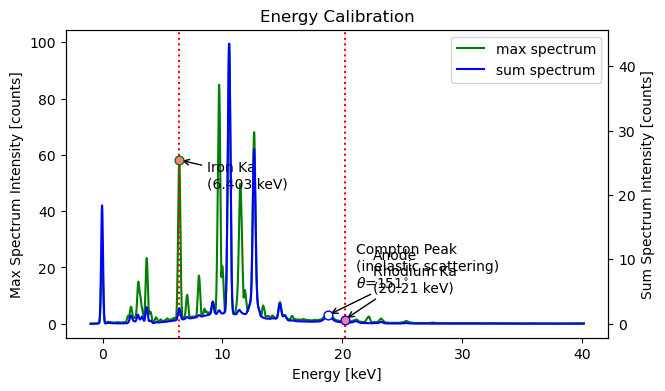


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack


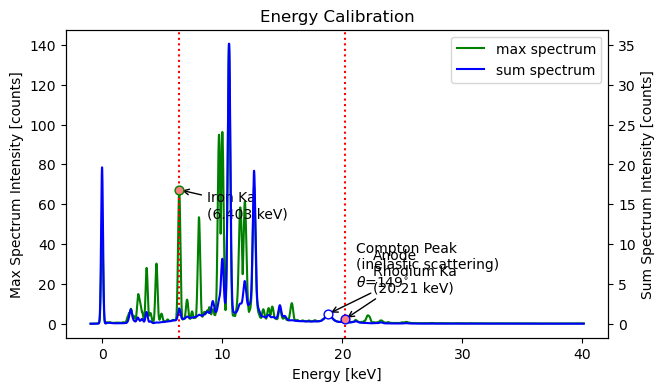


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack


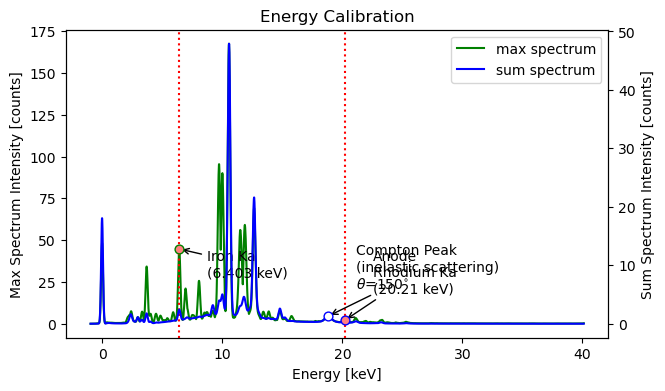


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack


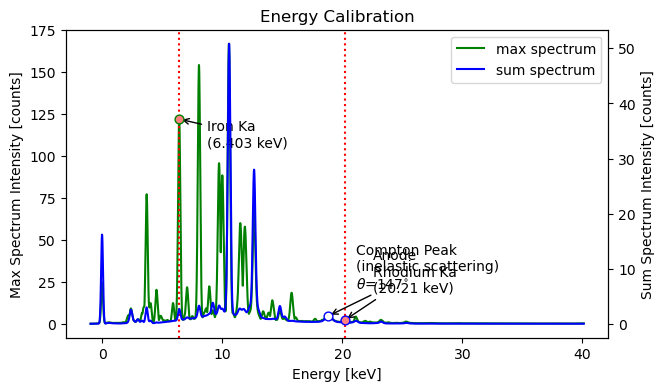


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack


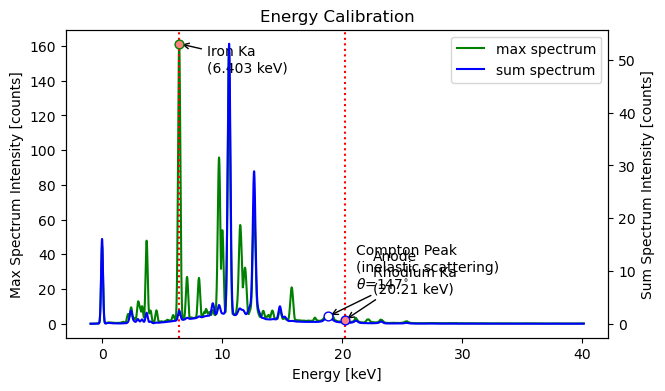


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack


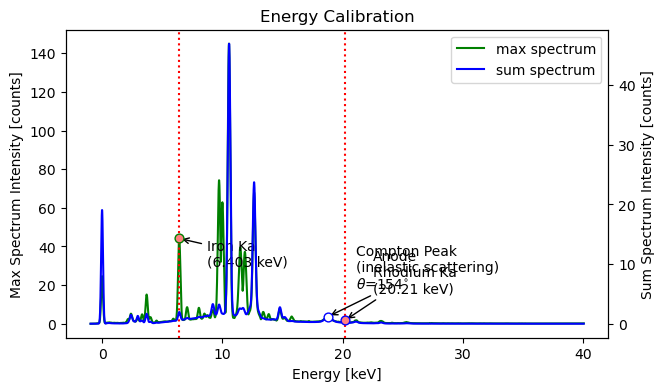


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack


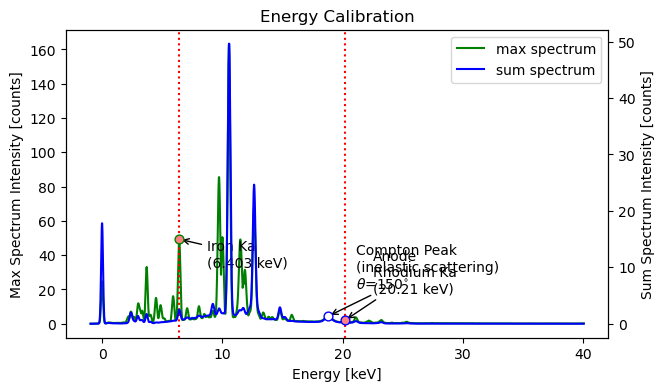


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack


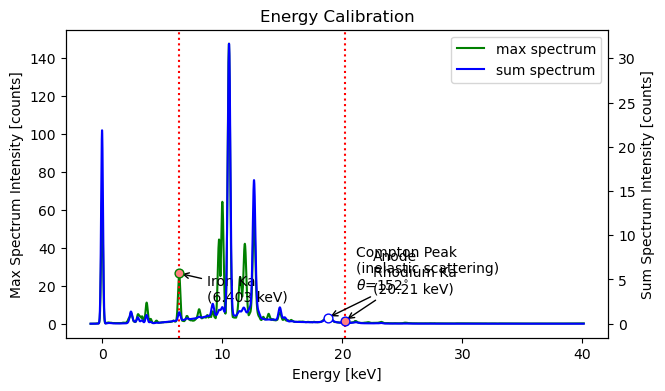


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack


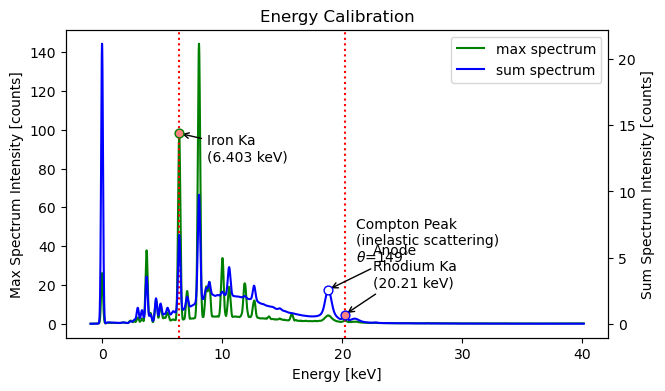


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-19_400_300_50_det.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-19_400_300_50_det.datastack


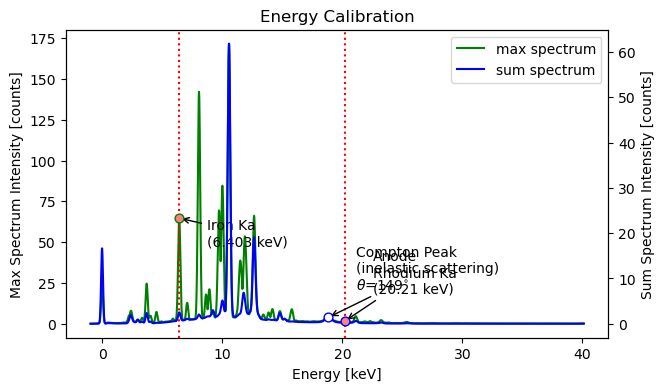


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack


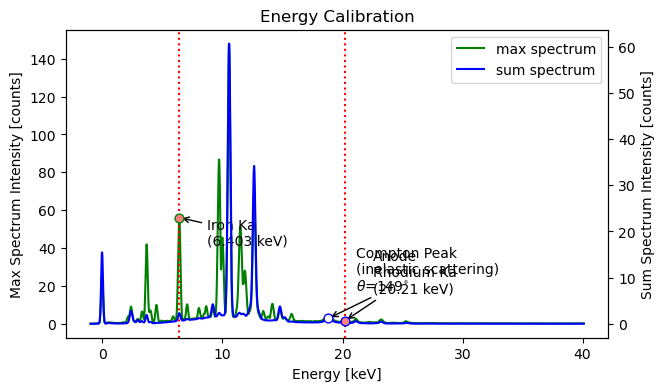


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack


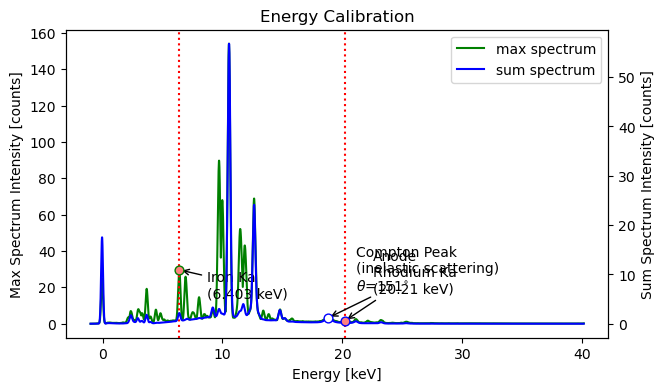


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack


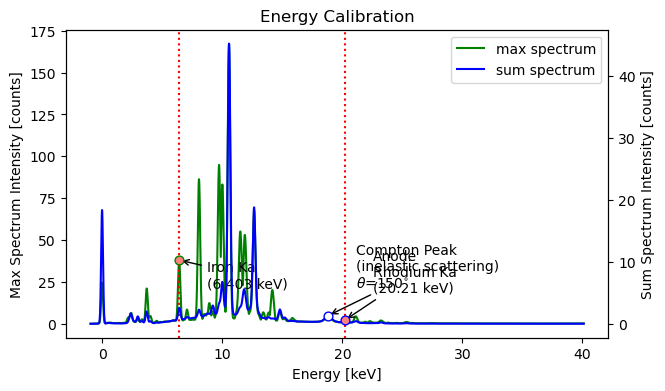


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack


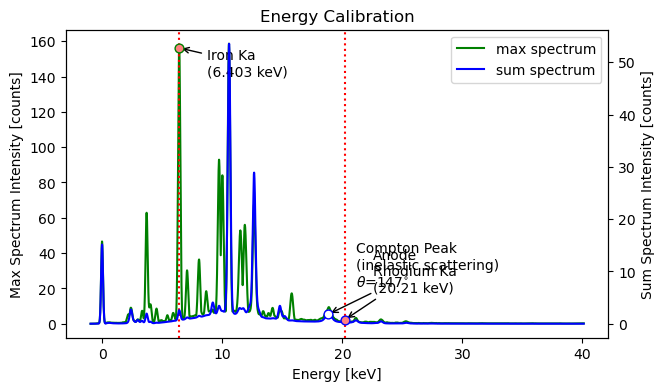


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-30_250_300_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-30_250_300_50.datastack


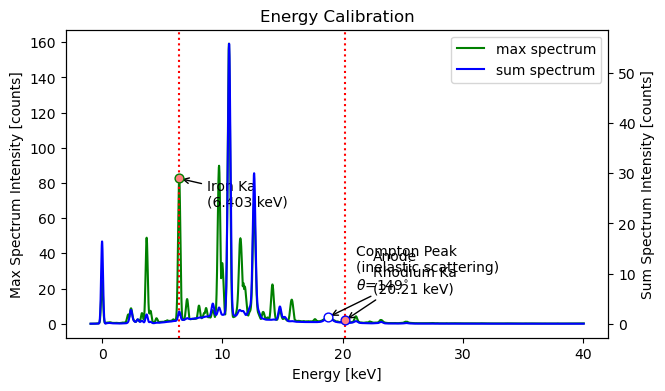


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-31_400_600_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-31_400_600_50.datastack


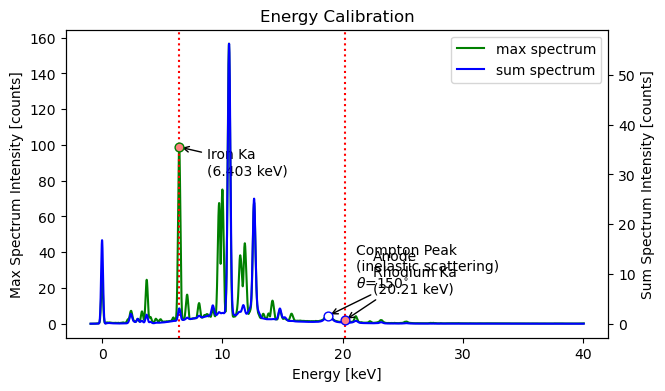


Writing channel energies (keV) to: ./data/interim/maxrf/datastacks/WM-71803-35_400_500_50.datastack
Also writing instrument Compton anode peak energy (keV) to: ./data/interim/maxrf/datastacks/WM-71803-35_400_500_50.datastack


In [7]:
for dsf in datastack_files: 
    mx.calibrate(dsf, auto_write=True)

In [8]:
datastack_files = sorted(glob('./data/interim/**/*.datastack', recursive=True)) 
n_files = len(datastack_files)
list(enumerate(datastack_files))

[(0, './data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack'),
 (1, './data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack'),
 (2, './data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack'),
 (3, './data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack'),
 (4, './data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack'),
 (5, './data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack'),
 (6, './data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack'),
 (7, './data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack'),
 (8, './data/interim/maxrf/datastacks/WM-71803-19_400_300_50_det.datastack'),
 (9, './data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack'),
 (10, './data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack'),
 (11, './data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack'),
 (12, './data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack'),
 (13, './data/interim/maxrf/dat

Step 1/3: Reading hot max channel maps...
[########################################] | 100% Completed | 25.71 s
Step 2/3: Locating hot max pixels...
Step 3/3: Ready with reading hot max spectra. 

Saved hotmax data to: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack
Step 1/3: Reading hot max channel maps...
[########################################] | 100% Completed | 147.28 s
Step 2/3: Locating hot max pixels...
Step 3/3: Ready with reading hot max spectra. 

Saved hotmax data to: ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack
Step 1/3: Reading hot max channel maps...
[########################################] | 100% Completed | 161.34 s
Step 2/3: Locating hot max pixels...
Step 3/3: Ready with reading hot max spectra. 

Saved hotmax data to: ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack
Step 1/3: Reading hot max channel maps...
[########################################] | 100% Completed | 142.10 s
Step 2/3: Locating hot max pixels

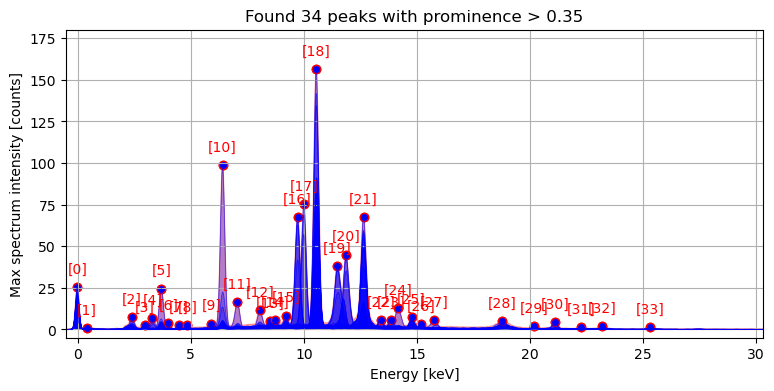

In [9]:
for dsf in datastack_files:
    plt.close('all') # perhaps needed to avoid crash? 
    mx.compute_hotmax_spectra(dsf, auto_write=True)
    

In [10]:
datastack_files = sorted(glob('./data/interim/**/*.datastack', recursive=True)) 
n_files = len(datastack_files)
list(enumerate(datastack_files))

[(0, './data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack'),
 (1, './data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack'),
 (2, './data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack'),
 (3, './data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack'),
 (4, './data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack'),
 (5, './data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack'),
 (6, './data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack'),
 (7, './data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack'),
 (8, './data/interim/maxrf/datastacks/WM-71803-19_400_300_50_det.datastack'),
 (9, './data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack'),
 (10, './data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack'),
 (11, './data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack'),
 (12, './data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack'),
 (13, './data/interim/maxrf/dat

In [11]:
for dsf in datastack_files: 
    mx.compute_hotmax_noise(dsf, auto_write=True)

Ready computing 32 noise envelopes.                           


Saved hotmax noise data to: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack
Ready computing 33 noise envelopes.                           


Saved hotmax noise data to: ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack
Ready computing 35 noise envelopes.                           


Saved hotmax noise data to: ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack
Ready computing 35 noise envelopes.                           


Saved hotmax noise data to: ./data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack
Ready computing 34 noise envelopes.                           


Saved hotmax noise data to: ./data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack
Ready computing 29 noise envelopes.                           


Saved hotmax noise data to: ./data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack
Ready computing 34 noise envelopes.                 

In [13]:
for dsf in datastack_files: 
    print(f'Computing subpeaks for: {dsf}...')
    mx.compute_subpeaks(dsf, auto_write=True)

Computing subpeaks for: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack...

Saved hotmax subpeak indexes list to: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack
Computing subpeaks for: ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack...

Saved hotmax subpeak indexes list to: ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack
Computing subpeaks for: ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack...

Saved hotmax subpeak indexes list to: ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack
Computing subpeaks for: ./data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack...

Saved hotmax subpeak indexes list to: ./data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack
Computing subpeaks for: ./data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack...

Saved hotmax subpeak indexes list to: ./data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack
Computing subpeaks f

I think so. 

In [14]:
datastack_files = sorted(glob('./data/interim/**/*.datastack', recursive=True)) 
n_files = len(datastack_files)
list(enumerate(datastack_files))

[(0, './data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack'),
 (1, './data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack'),
 (2, './data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack'),
 (3, './data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack'),
 (4, './data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack'),
 (5, './data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack'),
 (6, './data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack'),
 (7, './data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack'),
 (8, './data/interim/maxrf/datastacks/WM-71803-19_400_300_50_det.datastack'),
 (9, './data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack'),
 (10, './data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack'),
 (11, './data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack'),
 (12, './data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack'),
 (13, './data/interim/maxrf/dat

In [15]:
for dsf in datastack_files: 
    print(f'Computing peak maps for: {dsf}')
    mx.compute_nmf_peakmaps(dsf, auto_write=True)

Computing peak maps for: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack
Please wait a few minutes while preparing your peak maps. 
Computing factorization for spectral chunk 4/4...
Saved NMF peak maps data to: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack
Computing peak maps for: ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack
Please wait a few minutes while preparing your peak maps. 
Computing factorization for spectral chunk 16/16...
Saved NMF peak maps data to: ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack
Computing peak maps for: ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack
Please wait a few minutes while preparing your peak maps. 
Computing factorization for spectral chunk 15/15...
Saved NMF peak maps data to: ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack
Computing peak maps for: ./data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack
Please wait a few minutes w

Before computing the element maps, I would like to inspect the peak pattern puzzle for the combined maps. Not sure which elements we need...

In [16]:
datastack_files = sorted(glob('./data/interim/**/*.datastack', recursive=True)) 
n_files = len(datastack_files)
list(enumerate(datastack_files))

[(0, './data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack'),
 (1, './data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack'),
 (2, './data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack'),
 (3, './data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack'),
 (4, './data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack'),
 (5, './data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack'),
 (6, './data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack'),
 (7, './data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack'),
 (8, './data/interim/maxrf/datastacks/WM-71803-19_400_300_50_det.datastack'),
 (9, './data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack'),
 (10, './data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack'),
 (11, './data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack'),
 (12, './data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack'),
 (13, './data/interim/maxrf/dat

In [16]:
EOI = ['#H', '#He', '#Li', '#Be', '#B', '#C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 
       '#Ar', 'K', 'Ca', '#Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', '#Ga', '#Ge', 'As', 
       '#Se', 'Br', '#Kr', '#Rb', 'Sr', '#Y', 'Zr', '#Nb', '#Mo', '#Tc', '#Ru', 'Rh', '#Pd', 'Ag', 'Cd', 
       '#In', 'Sn', '#Sb', '#Te', 'I', '#Xe', '#Cs', 'Ba', '#La', '#Hf', '#Ta', '#W', '#Re', '#Os', '#Ir', 
       '#Pt', 'Au', 'Hg', '#Tl', 'Pb', '#Bi', '#Po', '#At', '#Rn', '#Fr', '#Ra', '#Ac', '#Rf', '#Db', '#Sg', 
       '#Bh', '#Hs', '#Mt', '#Ds', '#Rg', '#Cn', '#Nh', '#Fl', '#Mc', '#Lv', '#Ts', '#Og']

In [19]:
n = 0 
datastack_file = datastack_files[n]
ppa = mx.Peak_Pattern_Atlas(elements_of_interest=EOI, datastack_file=datastack_file, tube_keV=30)

Please wait while initializing peak pattern atlas...


In [20]:
%matplotlib widget

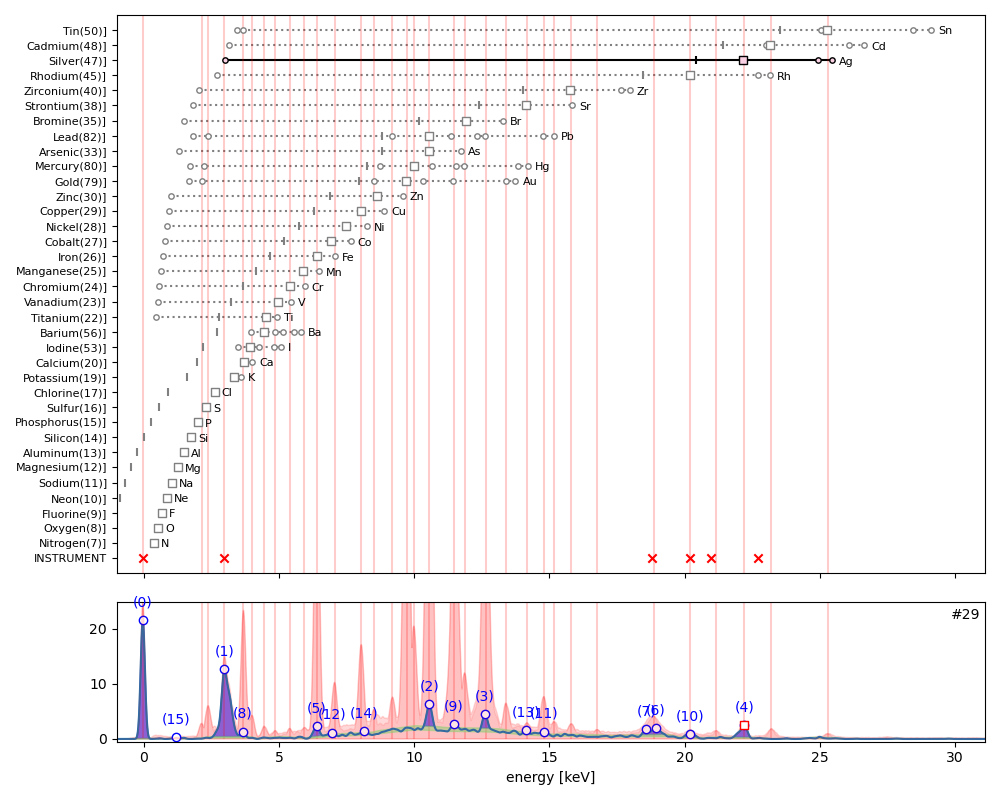

In [29]:
ppa.plot_puzzle(29, select_elems=['Ag'])